In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

%matplotlib inline

In [2]:
#Get Dataset paths
train_path = '/kaggle/input/indian-birds/Birds_25/train'
test_path = '/kaggle/input/indian-birds/Birds_25/valid'

#Create TF datasets from directory
train_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(156, 156),
    seed=123,
    shuffle=True,
    validation_split=0.2,
    subset='training')
val_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(156, 156),
    seed=123,
    shuffle=True,
    validation_split=0.2,
    subset='validation')
test_set = tf.keras.utils.image_dataset_from_directory(
    test_path,
    batch_size=32,
    image_size=(156, 156),
    shuffle=False,
    seed=123)
print(train_set.element_spec)
print(val_set.element_spec)

Found 30000 files belonging to 25 classes.
Using 24000 files for training.
Found 30000 files belonging to 25 classes.
Using 6000 files for validation.
Found 7500 files belonging to 25 classes.
(TensorSpec(shape=(None, 156, 156, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 156, 156, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [3]:
#Get class names
class_names = val_set.class_names
print(class_names)

['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']


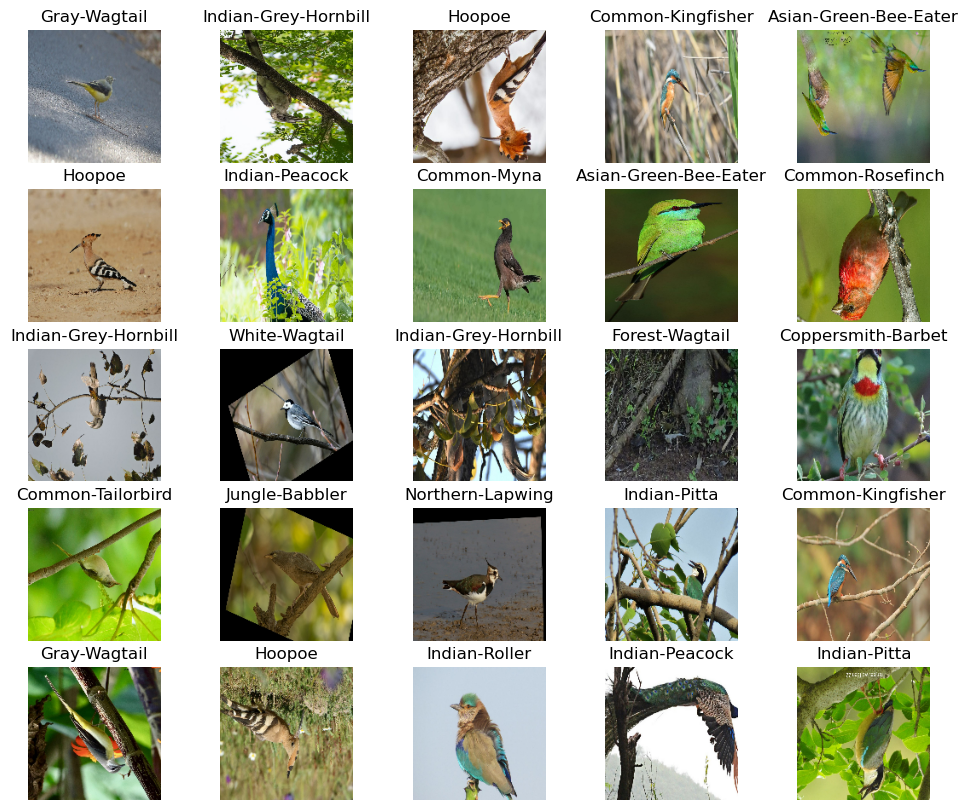

In [4]:
#Visualize dataset
plt.figure(figsize=(12, 10))
for images, labels in train_set.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
#Create one hot matrix 
train_set = train_set.map(lambda x, y: (x, tf.cast(tf.one_hot(y, 25), tf.uint8)))
val_set = val_set.map(lambda x, y: (x, tf.cast(tf.one_hot(y, 25), tf.uint8)))
test_set = test_set.map(lambda x, y: (x, tf.cast(tf.one_hot(y, 25), tf.uint8)))

print(train_set.element_spec)
print(val_set.element_spec)

(TensorSpec(shape=(None, 156, 156, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25), dtype=tf.uint8, name=None))
(TensorSpec(shape=(None, 156, 156, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 25), dtype=tf.uint8, name=None))


In [6]:
#Create identity block(input and output have same dimensions) function for ResNet
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    
    ## Add shortcut value to main path, and pass through a RELU activation
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [7]:
#Create convolutional block(input and output have different dimensions) function for ResNet
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    
    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    
    
    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    
    #Add shortcut value to main path and pass through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
#ResNet Model with 50 layers
def ResNet50(input_shape = (64, 64, 3), classes = 25):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    #Image normalization
    X = tf.keras.layers.Rescaling(1./255)(X_input)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, f = 3, filters = [512, 512, 2048])
    X = identity_block(X, f = 3, filters = [512, 512, 2048])

    # AVGPOOL
    X = tf.keras.layers.AveragePooling2D()(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [9]:
#Create model object with shape (156, 156, 3) get summary
model = ResNet50(input_shape = (156, 156, 3), classes = 25)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156, 156, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 162, 162, 3)  0          ['rescaling[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 78, 78, 64)   9472        ['zero_padding2d[0][0]']     

In [10]:
#Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [11]:
#Train ResNet50 model
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_set.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_set.cache().prefetch(buffer_size=AUTOTUNE)

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
750/750 [==============================] - 315s 369ms/step - loss: 2.5910 - accuracy: 0.2515 - val_loss: 1.9670 - val_accuracy: 0.3877
Epoch 2/20
750/750 [==============================] - 84s 112ms/step - loss: 1.6767 - accuracy: 0.4792 - val_loss: 1.4501 - val_accuracy: 0.5493
Epoch 3/20
750/750 [==============================] - 84s 112ms/step - loss: 1.2236 - accuracy: 0.6219 - val_loss: 1.1519 - val_accuracy: 0.6565
Epoch 4/20
750/750 [==============================] - 84s 112ms/step - loss: 0.9199 - accuracy: 0.7200 - val_loss: 0.9858 - val_accuracy: 0.6953
Epoch 5/20
750/750 [==============================] - 85s 113ms/step - loss: 0.7057 - accuracy: 0.7807 - val_loss: 0.9950 - val_accuracy: 0.7082
Epoch 6/20
750/750 [==============================] - 84s 111ms/step - loss: 0.5544 - accuracy: 0.8236 - val_loss: 1.0362 - val_accuracy: 0.6980
Epoch 7/20
750/750 [==============================] - 84s 111ms/step - loss: 0.4339 - accuracy: 0.8593 - val_loss: 0.9411 - val_a

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

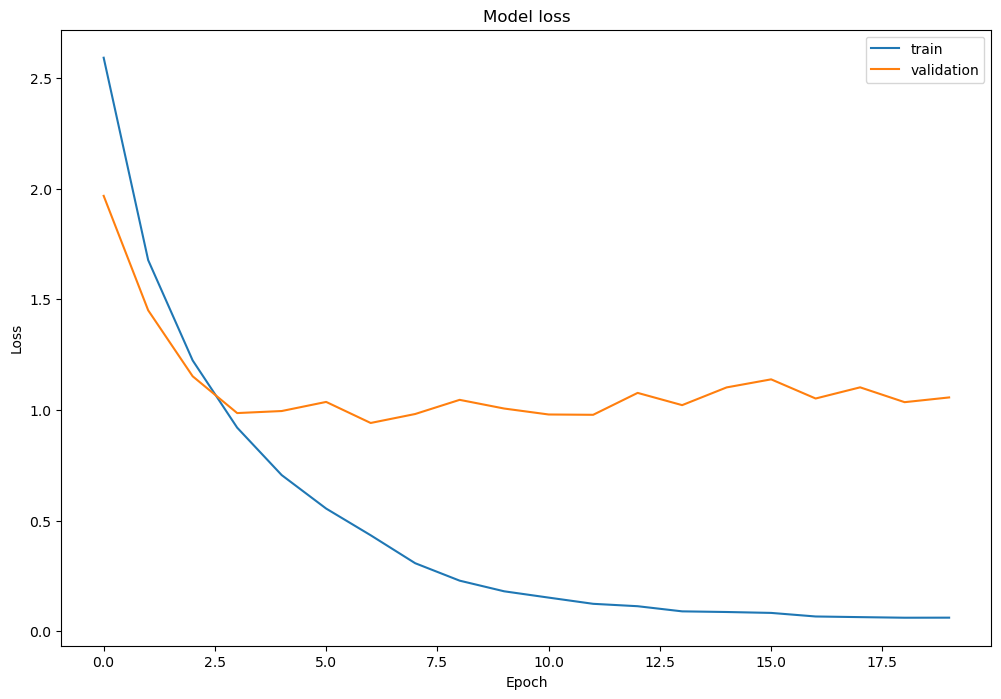

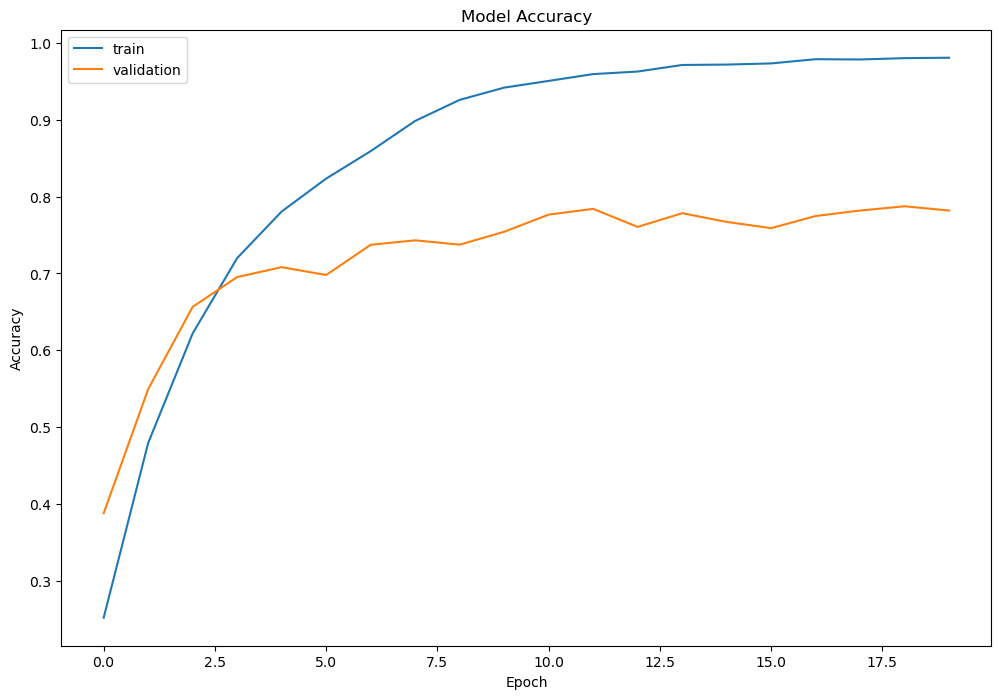

In [12]:
#Plot Loss and Accuracy from history
df_loss_acc = pd.DataFrame(history.history)
print(df_loss_acc.columns)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [13]:
model.evaluate(test_set)

235/235 [==============================] - 60s 256ms/step - loss: 4.2822 - accuracy: 0.4069


[4.28224515914917, 0.40693333745002747]